In [42]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [72]:
#filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/ttHbb/store/mc/RunIISummer20UL18NanoAODv9/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2500000/6BF93845-49D5-2547-B860-4F7601074715.root"
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/ttHbb/store/mc/RunIISummer20UL18NanoAODv9/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/130000/44187D37-0301-3942-A6F7-C723E9F4813D.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=500000).events()

In [4]:
events

<NanoEventsArray [<event 1:694:693011>, ... ] type='10000 * event'>

# btagSF computation

In [3]:
import correctionlib
cset = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/BTV/2018_UL/btagging.json.gz")

In [6]:
corr = cset["deepJet_shape"]

In [9]:
corr.description

'deepJet reshaping scale factors for UL 2018. The scale factors have 8 default uncertainty sources (hf,lf,hfstats1/2,lfstats1/2,cferr1/2). All except the cferr1/2 uncertainties are to be applied to light and b jets. The cferr1/2 uncertainties are to be applied to c jets. hf/lfstats1/2 uncertainties are to be decorrelated between years, the others correlated. Additional jes-varied scale factors are supplied to be applied for the jes variations.'

In [186]:
mask = (events.Jet.pt >= 30) & (abs(events.Jet.eta) < 2.5) & (events.Jet.hadronFlavour==4)

In [177]:
event.Jet.pt.to_numpy()

NameError: name 'event' is not defined

In [187]:
flavour = ak.to_numpy(ak.flatten(events.Jet.hadronFlavour[mask]))
abseta = np.abs(ak.to_numpy(ak.flatten(events.Jet.eta[mask])))
pt = ak.to_numpy(ak.flatten(events.Jet.pt[mask]))
discr = ak.to_numpy(ak.flatten(events.Jet.btagDeepFlavB[mask]))
njet = ak.num(events.Jet[mask])

In [189]:
w = corr.evaluate("up_hf", flavour, abseta, pt, discr)
weight = ak.unflatten(w, njet)

IndexError: Index not available in Category for input argument 1 val: 4

In [100]:
event_weight= ak.prod(weight, axis=-1)

In [39]:
weight[0:10].tolist()

[[0.892459452152, 1.1656756978985454, 1.1749574647350498],
 [0.922901451588, 1.2474655114519857, 0.9010124804992585],
 [0.9877053857215878, 0.9237691850699223],
 [1.3911254231799035,
  0.922901451588,
  0.922487258911,
  1.043259006215633,
  1.2636238451666324,
  1.1553113559981159],
 [1.126291075348247, 0.9820121197501579],
 [1.2375444182754247,
  0.892459452152,
  1.1285838313371372,
  0.922487258911,
  1.2327920491129214],
 [0.9867450798981254, 0.922487258911],
 [0.9790917325371903,
  0.9450608104527708,
  1.018647049217641,
  1.325376296972817],
 [1.0415900525345414, 0.922487258911, 0.922487258911, 0.9441756694172634],
 [1.2253446251960833, 0.7259000916546433, 1.058576753606894]]

In [44]:
import os
os.chdir('../..')

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

from coffea.util import load
from coffea.hist import plot
import numpy as np
import pandas as pd

from pprint import pprint 
hep.style.use(hep.style.ROOT)

Text(0, 1, 'btag SF')

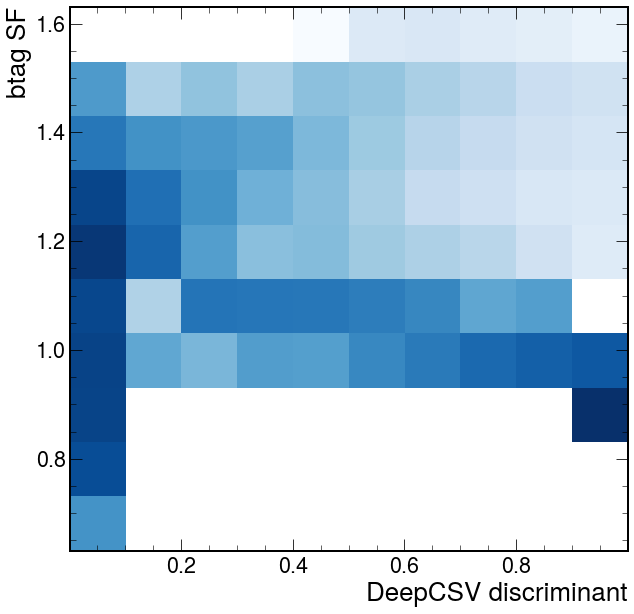

In [76]:
plt.hist2d(discr, w, norm=LogNorm(), cmap="Blues")
plt.xlabel("DeepCSV discriminant")
plt.ylabel("btag SF")

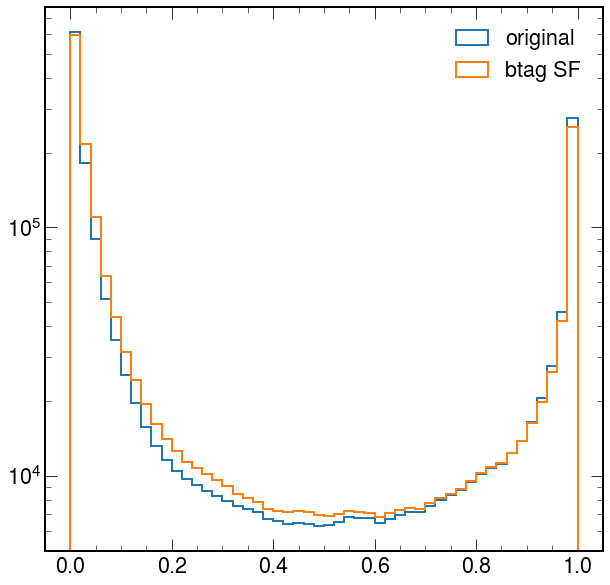

In [107]:
plt.hist(discr, range=(0,1), bins=50, histtype="step",linewidth=2, label="original")
plt.hist(discr, weights=w, range=(0,1), bins=50, histtype="step", linewidth=2,label="btag SF")
plt.legend()
plt.yscale("log")

(array([953252.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  32397., 737690.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

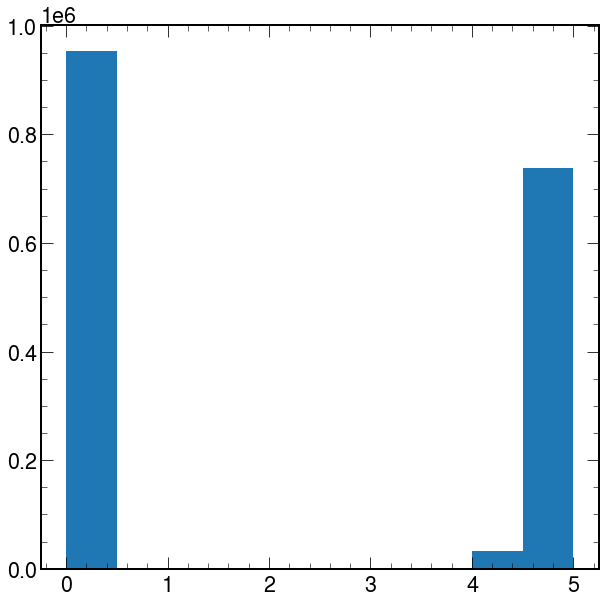

In [79]:
plt.hist(flavour)

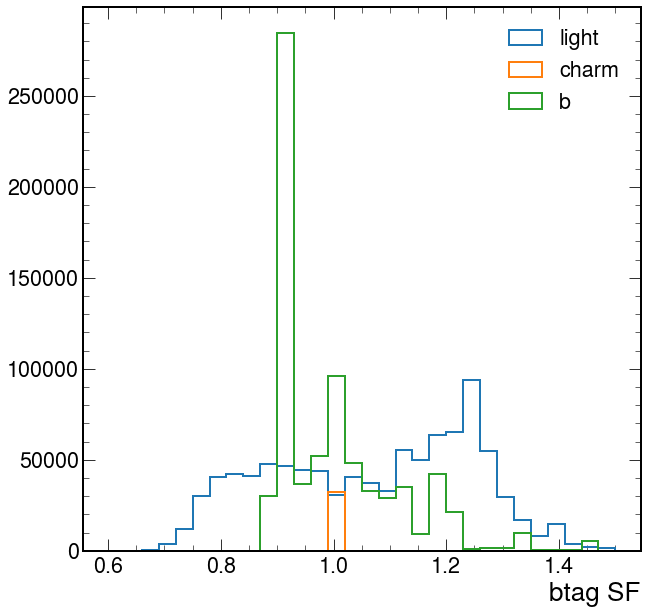

In [110]:
plt.hist(w[flavour==0], bins=30, range=(0.6,1.5),histtype="step",linewidth=2, label="light" )
plt.hist(w[flavour==4], bins=30, range=(0.6,1.5),histtype="step", linewidth=2,label="charm" )
plt.hist(w[flavour==5], bins=30, range=(0.6,1.5),histtype="step", linewidth=2, label="b")
plt.xlabel("btag SF")
plt.legend()

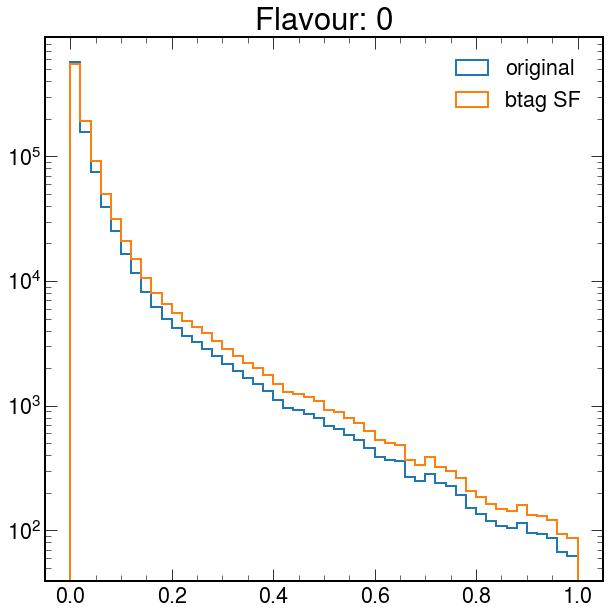

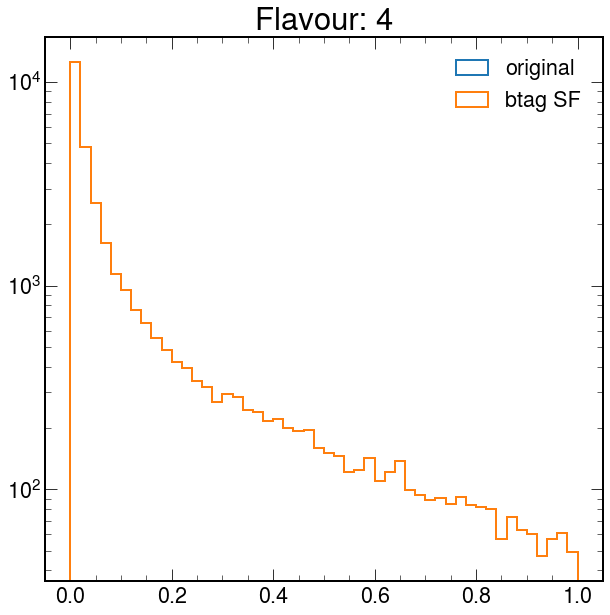

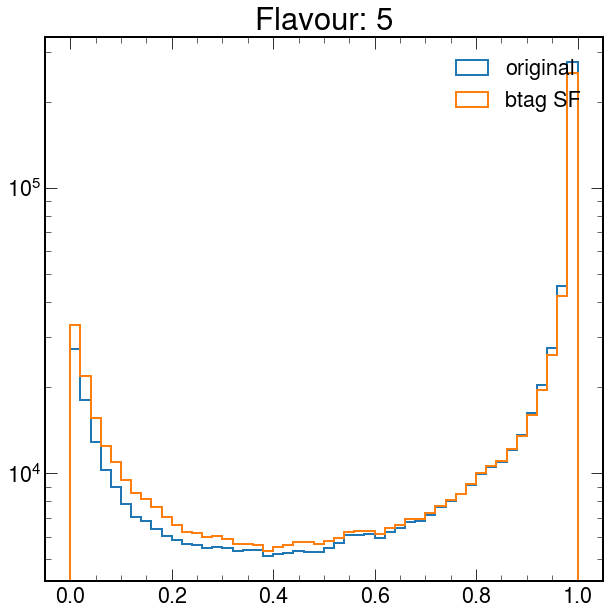

In [106]:
for fl in [0,4,5]:
    mask = flavour==fl
    plt.hist(discr[mask], range=(0,1), bins=50, histtype="step",linewidth=2, label="original")
    plt.hist(discr[mask], weights=w[mask], range=(0,1), bins=50, linewidth=2,histtype="step", label="btag SF")
    plt.title(f"Flavour: {fl}")
    plt.legend()
    plt.yscale("log")
    plt.show()

## Overall normalization pre/post btagSF

Text(1, 0, 'Inclusive N. jets')

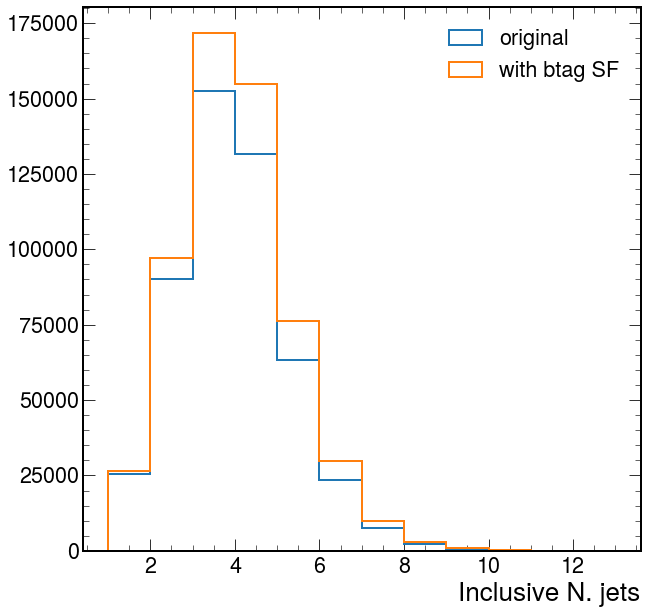

In [116]:
H, *_ = plt.hist(njet, bins=12, range=(1, 13),histtype="step", label="original", linewidth=2)
Hsf, *_  = plt.hist(njet, weights=event_weight, bins=12, range=(1, 13),histtype="step", label="with btag SF", linewidth=2)
plt.legend()
plt.xlabel("Inclusive N. jets" )

In [127]:
import hist

In [156]:
H = (hist.Hist.new
     .StrCat(["original", "btagSF"], name="version")
    .Reg(9, 1, 10, name="njet")
    .Weight())

In [157]:
H.fill(version="original", njet=njet)
H.fill(version="btagSF", njet=njet, weight=event_weight)

Hist(
  StrCategory(['original', 'btagSF'], name='version', label='version'),
  Regular(9, 1, 10, name='njet', label='njet'),
  storage=Weight()) # Sum: WeightedSum(value=1.06616e+06, variance=1.20249e+06) (WeightedSum(value=1.07274e+06, variance=1.20936e+06) with flow)

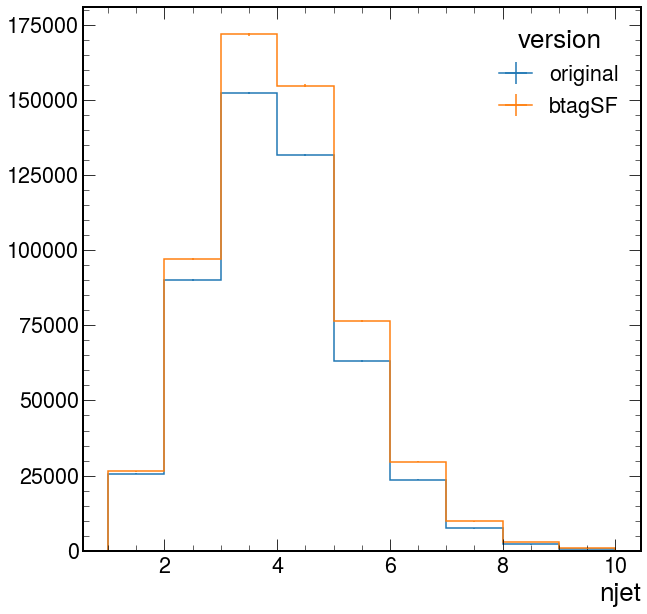

In [158]:
fig, ax = plt.subplots()
H[:, :].plot1d(ax=ax)
ax.legend(title="version")

In [159]:
num = H["original",:].values()
denom = H["btagSF", :].values()
sf = np.where(
    (num>0)&(denom>0), 
    num / denom, 
    1.0)
#

In [160]:
sfhist = hist.Hist(*H.axes[1:], data=sf)

Our SF is now an histogram and we can use it to convert it to correctionlib

In [161]:
sfhist

Hist(Regular(9, 1, 10, name='njet', label='njet'), storage=Double()) # Sum: 7.464676969939082

In [162]:
import correctionlib, rich
import correctionlib.convert

In [165]:
# without a name, the resulting object will fail validation
sfhist.name = "btagSF_norm_correction"
sfhist.label = "out"
clibcorr = correctionlib.convert.from_histogram(sfhist)
clibcorr.description = "SF to correct the overall normalization after the application of btagSF weights"
# set overflow bins behavior (default is to raise an error when out of bounds)
clibcorr.data.flow = "clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="btagSF normalization corrections",
    corrections=[clibcorr],
)
rich.print(cset)

with open("/work/dvalsecc/ttHbb/PocketCoffea/notebooks/mycorrections_test.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
btagSF normalization corrections
📂
└── 📈 btagSF_norm_correction (v0)
    SF to correct the overall normalization after the application of btagSF weights
    Node counts: Binning: 1
    ╭──────────── ▶ input ────────────╮
    │ njet (real)                     │
    │ njet                            │
    │ Range: [1.0, 10.0), overflow ok │
    ╰─────────────────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

In [166]:
ceval = cset.to_evaluator()

In [172]:
ceval['btagSF_norm_correction'].evaluate(np.array([1,2,3,4,4,4,5,56,9,10, 0, -1]))

array([0.96640931, 0.92905519, 0.88723484, 0.85111607, 0.85111607,
       0.85111607, 0.82725979, 0.70738233, 0.70738233, 0.70738233,
       0.96640931, 0.96640931])